In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pydub import AudioSegment
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
import IPython.display as ipd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda

In [19]:
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]


def create_new_path(file_path):
    parts = file_path.rsplit('.', 1)
    return f"{parts[0]}-new.{parts[1]}"

In [3]:
text_dict = {
1 : "When she was a child Jennifer liked sports and she played hockey and basketball for an all-boys team. She also worked as a model. At the age of 14 she knew she wanted to be an actress, so she went to New York City to look for work. She appeared in advertisements for MTV and the fashion company Zara and got work as an actress on TV. Her family moved to Los Angeles so that Jennifer could work on TV and in films.",
2 : "Monday is viewed by many to be the worst day of the week, as it marks the return to work following the weekend, when most full-time employees are given two days off. Most students attend school in the morning and return home in the afternoon (usually from about eight until three or seven until two), and most workers go to work in the morning and return home in the evening (usually from nine to five or eight to four).",
3 : "London is a famous and historic city. It is the capital of England in the United Kingdom. The city is quite popular for international tourism because London is home to one of the oldest-standing monarchies in the western area. Rita and Joanne recently travelled to London. They were very excited for their trip because this was their first journey overseas from the United States.",
4 : "I am living with a very welcoming host family. I have my own private bedroom, but we eat breakfast, lunch, and dinner together. On Sundays, we eat a big home-cooked soup for lunch. In Spain, lunch is usually the biggest meal of the day. It's also very common for people to take a midday nap right after a big meal. I am actually just waking up from my nap right now!",
5 : "My name is Bob. Each day I drive my kids to school. My daughter goes to a school that’s far from our house. It takes 30 minutes to get there. Then I drive my son to his school. It’s close to my job. My daughter is in the sixth grade and my son is in the second. They are both good students. My daughter usually sings her favourite songs while I drive. My son usually sleeps.",
6 : "A red and yellow flag tells you to swim between the flags. They show the supervised area of the beach. This means that lifeguards are watching that area. If there are no red and yellow flags it means there is no supervision. Check with the lifeguards and if you are unsure do not go into the water. Black and white check flag shows where board riding and surfing is not allowed.",
7 : "Lucas goes to school every day of the week. He has many subjects to go to each school day: English, art, science, mathematics, gym, and history. His mother packs a big backpack full of books and lunch for Lucas. His first class is English, and he likes that teacher very much. His English teacher says that he is a good pupil, which Lucas knows means that she thinks he is a good student.",
8 : "You can also take one small laptop bag or handbag that can fit under the seat in front of you. If you have two bags, their total weight cannot be more than the limit. If your bag is too big or too heavy, you will not be allowed to take it onto the plane. Staff will put it in the hold for you and you will have to pay extra. Please make sure mobile phones and other devices are fully-charged so security staff can check them.",
9 : "I live in an apartment. In my city, there is a post office where people mail letters. On Monday, I go to work. I work at the post office. Everyone shops for food at the grocery store. They also eat at the restaurant. The restaurant serves pizza and ice cream. My friends and I often go to the park. We like to play soccer at the park. On Fridays, we go to the cinema to see a movie.",
10 : "Chocolates and flowers are commonly given as gifts during Valentine's Day, as are accompanying greeting cards. Red and pink are generally understood to be the colours of Valentine's Day, and many individuals, instead of celebrating romantically, spend the holiday with their friends or family members."
  }

In [4]:
texts_uncleaned = pd.read_csv("result.csv")
temp = texts_uncleaned[texts_uncleaned['INPUT:audio'] == 'https://storage.yandexcloud.net/toloka-chebotarev/TextR_1.0.wav']
# texts_uncleaned = texts_uncleaned[texts_uncleaned['INPUT:audio'] != 'https://storage.yandexcloud.net/toloka-chebotarev/TextR_1.0.wav']
temp

,Unnamed: 0,INPUT:audio,INPUT:image,OUTPUT:recording,OUTPUT:result_3d_question,OUTPUT:result_1st_question,OUTPUT:result_2nd_question,OUTPUT:result_4th_question,ASSIGNMENT:assignment_id,ASSIGNMENT:worker_id,speechkit_path,file_path,duration,new_path,new_speechkit_path,assigned_text,transcribed_text
0,0,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7cc55f72-618c-4ac6-ae75-d9a27bdec249,No,No,No,No,00028edf7c--6613eacdecfe467e31a1b8cb,b2c2c06f6bf8eed800e25881029fbcf7,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,66.720,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,1,When she was a child jennifer jennifer liked s...
2,2,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7e09aeb4-fa43-4c93-9434-983c2cf8495b,No,No,No,No,00028edf7c--6613eaf349336b29782c8615,6e9fdeeb3d0dfb1afd888aa5c8d347e6,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,24.540,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,London is a famous and historic city it is the...
4,4,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.440419a1-a930-4eb2-b965-fb45c69df94e,No,No,No,No,00028edf7c--6613eb6d4e5be33a301c075d,6de9d807930d55fdddfaf3eecd0c8c13,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,40.340,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,1,When she was a child jennifer light sports and...
5,5,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.9ed5db0e-2ef0-4f2f-b2d4-831e52e2e061,No,No,No,No,00028edf7c--6613eb864e5be33a301c0a24,88068638195ce4efc7331d5bd197d567,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,35.680,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,London is a famous honey historic city is the ...
7,7,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.1a5a377e-e993-4275-a794-0f3ff426d78d,No,No,No,No,00028edf7c--6613eb9eecfe467e31a1cf9b,3a65cde2fe52f27a7bdf0dc6037605f8,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,24.020,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,London is a famous and historic city it is the...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4745,4745,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.c022d255-0763-448a-a85f-fb6730bd8286,None of the above,No,No,None of the above,00028ffbe7--664b29c1fb6c1e0937d276af,184f7142868b431137e0ab7b0275b6d5,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,24.661,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,4,I am living in the very welcome and host famil...
4746,4746,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.b36d0abf-abbd-44b4-9b19-fae23ad19f46,None of the above,No,No,None of the above,00028ffbe7--664b66a85a649d7d7f40f25e,fe7307c3a5a0c53e69376ac7ceff408e,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,30.200,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,6,A red and yellow flag tells you to swim betwee...
4750,4750,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.3c9bbea9-950f-4c10-8cb2-aadc32d299e5,None of the 

In [5]:
texts_uncleaned['duration'].nsmallest(5)
texts = texts_uncleaned.dropna(subset=['transcribed_text'])

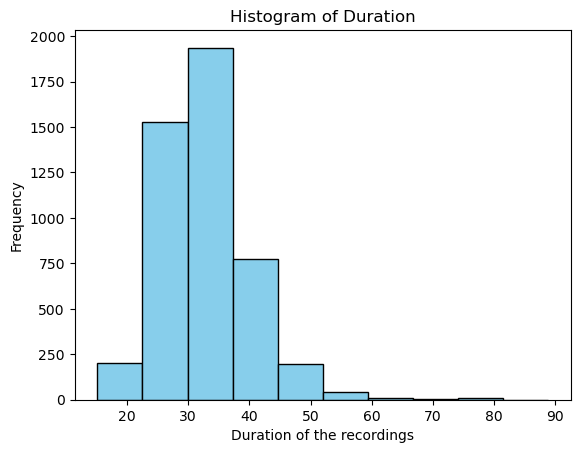

In [6]:
plt.hist(texts['duration'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Duration of the recordings')
plt.ylabel('Frequency')
plt.title('Histogram of Duration')

# Display the plot
plt.show()


In [7]:
texts

,Unnamed: 0,INPUT:audio,INPUT:image,OUTPUT:recording,OUTPUT:result_3d_question,OUTPUT:result_1st_question,OUTPUT:result_2nd_question,OUTPUT:result_4th_question,ASSIGNMENT:assignment_id,ASSIGNMENT:worker_id,speechkit_path,file_path,duration,new_path,new_speechkit_path,assigned_text,transcribed_text
0,0,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7cc55f72-618c-4ac6-ae75-d9a27bdec249,No,No,No,No,00028edf7c--6613eacdecfe467e31a1b8cb,b2c2c06f6bf8eed800e25881029fbcf7,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,66.720,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,1,When she was a child jennifer jennifer liked s...
1,1,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.c334a2ee-536d-43a3-8f67-972fb9d50d7a,Yes,Yes,No,No,00028edf7c--6613ead849336b29782c831c,6a77f4ba1d04551c0c776dbd7b38e2f5,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,36.880,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,London is a famous and if her historical city ...
2,2,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7e09aeb4-fa43-4c93-9434-983c2cf8495b,No,No,No,No,00028edf7c--6613eaf349336b29782c8615,6e9fdeeb3d0dfb1afd888aa5c8d347e6,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,24.540,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,London is a famous and historic city it is the...
3,3,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.e0508876-bb3a-4de0-a8ce-c222dd87f1ba,No,No,Yes,Yes,00028edf7c--6613eb144e5be33a301bfdde,f91d95a62d1c07da5f4ddae20e7e6b14,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,31.940,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,London is a famous and historic city it is the...
4,4,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.440419a1-a930-4eb2-b965-fb45c69df94e,No,No,No,No,00028edf7c--6613eb6d4e5be33a301c075d,6de9d807930d55fdddfaf3eecd0c8c13,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,40.340,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,1,When she was a child jennifer light sports and...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4763,4763,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7fcdde19-4b38-4a44-8dc7-a0c68ebb2d06,No,No,Yes,Yes,00028ffbe7--664f07bb42ac8f441d6bf968,542fa70be325c67d6dbf1e376d74e32e,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,31.659,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,1,When she was a child jennifer liked sports and...
4764,4764,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.3569cba1-8e98-475a-84fe-971b0dc4c7e9,No,Yes,Yes,Yes,00028ffbe7--664f3cb542ac8f441d6f43be,4c8d438e586e0fec1b8ec7892d810e81,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,40.520,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,1,When she was a generic jennifer likes sports a...
4765,4765,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.2b5ec51b-70d7-4031-b831-afe54060cc27,No,No,Yes,Yes,00028ffbe7--664f4f6cdb902752cf421fd8,567dd66e382b

In [8]:
for index, row in texts.iterrows():
    try:
        texts.at[index, 'levenstein_distance'] = levenshtein_distance(row['transcribed_text'], text_dict[row['assigned_text']])
    except TypeError:
        print(index)

/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_83879/3166004113.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts.at[index, 'levenstein_distance'] = levenshtein_distance(row['transcribed_text'], text_dict[row['assigned_text']])


In [13]:
texts = texts[texts['INPUT:audio'] != 'https://storage.yandexcloud.net/toloka-chebotarev/TextR_1.0.wav']

In [10]:
texts

,Unnamed: 0,INPUT:audio,INPUT:image,OUTPUT:recording,OUTPUT:result_3d_question,OUTPUT:result_1st_question,OUTPUT:result_2nd_question,OUTPUT:result_4th_question,ASSIGNMENT:assignment_id,ASSIGNMENT:worker_id,speechkit_path,file_path,duration,new_path,new_speechkit_path,assigned_text,transcribed_text,levenstein_distance
0,0,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7cc55f72-618c-4ac6-ae75-d9a27bdec249,No,No,No,No,00028edf7c--6613eacdecfe467e31a1b8cb,b2c2c06f6bf8eed800e25881029fbcf7,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,66.720,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,1,When she was a child jennifer jennifer liked s...,99.0
1,1,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.c334a2ee-536d-43a3-8f67-972fb9d50d7a,Yes,Yes,No,No,00028edf7c--6613ead849336b29782c831c,6a77f4ba1d04551c0c776dbd7b38e2f5,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,36.880,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,London is a famous and if her historical city ...,88.0
2,2,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7e09aeb4-fa43-4c93-9434-983c2cf8495b,No,No,No,No,00028edf7c--6613eaf349336b29782c8615,6e9fdeeb3d0dfb1afd888aa5c8d347e6,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,24.540,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,London is a famous and historic city it is the...,28.0
3,3,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.e0508876-bb3a-4de0-a8ce-c222dd87f1ba,No,No,Yes,Yes,00028edf7c--6613eb144e5be33a301bfdde,f91d95a62d1c07da5f4ddae20e7e6b14,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,31.940,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,London is a famous and historic city it is the...,31.0
4,4,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.440419a1-a930-4eb2-b965-fb45c69df94e,No,No,No,No,00028edf7c--6613eb6d4e5be33a301c075d,6de9d807930d55fdddfaf3eecd0c8c13,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,40.340,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,1,When she was a child jennifer light sports and...,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4763,4763,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7fcdde19-4b38-4a44-8dc7-a0c68ebb2d06,No,No,Yes,Yes,00028ffbe7--664f07bb42ac8f441d6bf968,542fa70be325c67d6dbf1e376d74e32e,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,31.659,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,1,When she was a child jennifer liked sports and...,34.0
4764,4764,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.3569cba1-8e98-475a-84fe-971b0dc4c7e9,No,Yes,Yes,Yes,00028ffbe7--664f3cb542ac8f441d6f43be,4c8d438e586e0fec1b8ec7892d810e81,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,40.520,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,1,When she was a generic jennifer likes sports a...,105.0
4765,4765,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.2b5ec51b-70d7-4031-b831-afe54060cc27,No,

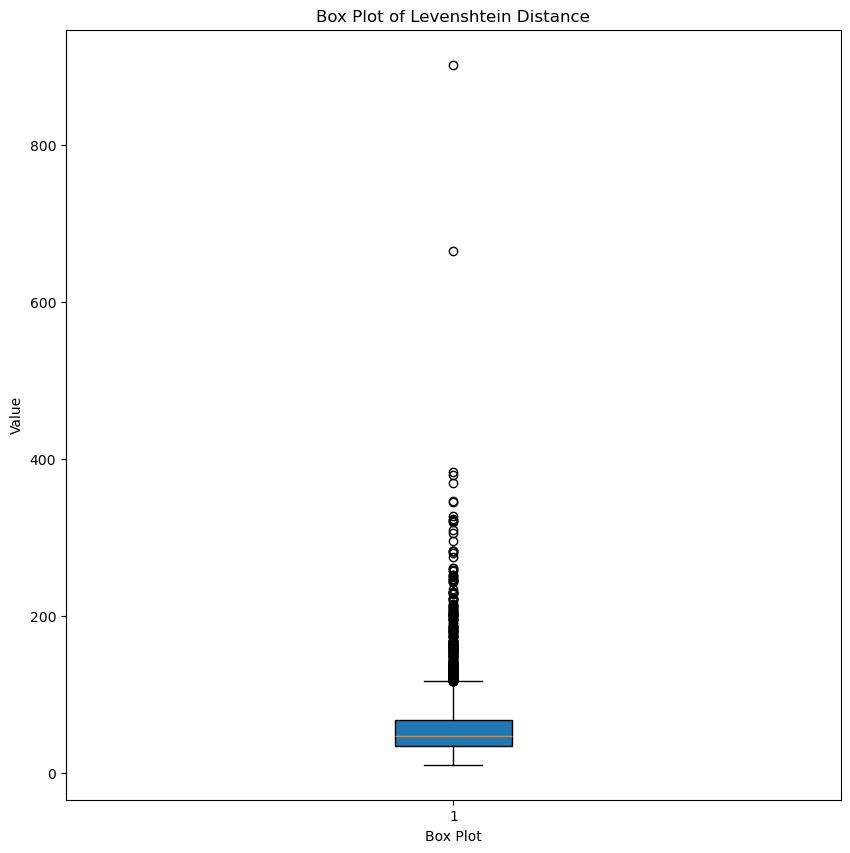

In [11]:
plt.figure(figsize=(10, 10))
plt.boxplot(texts['levenstein_distance'], vert=True, patch_artist=True)

plt.xlabel('Box Plot')
plt.ylabel('Value')
plt.title('Box Plot of Levenshtein Distance')

# Display the plot
plt.show()

# plt.hist(texts['levenstein_distance'], bins=10, color='skyblue', edgecolor='black')
# plt.xlabel('Levenshtein distance of recorded and given texts')
# plt.ylabel('Frequency')
# plt.title('Histogram of Levenshtein distance ')
# Display the plot
# plt.show()

In [12]:
quantiles = texts['levenstein_distance'].quantile([0.80, 0.85, 0.90, 0.95])
quantiles

0.80     75.0
0.85     85.0
0.90     98.0
0.95    125.0
Name: levenstein_distance, dtype: float64

In [14]:
texts = texts[texts['levenstein_distance'] <= 125.0]
texts

,Unnamed: 0,INPUT:audio,INPUT:image,OUTPUT:recording,OUTPUT:result_3d_question,OUTPUT:result_1st_question,OUTPUT:result_2nd_question,OUTPUT:result_4th_question,ASSIGNMENT:assignment_id,ASSIGNMENT:worker_id,speechkit_path,file_path,duration,new_path,new_speechkit_path,assigned_text,transcribed_text,levenstein_distance
1,1,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.c334a2ee-536d-43a3-8f67-972fb9d50d7a,Yes,Yes,No,No,00028edf7c--6613ead849336b29782c831c,6a77f4ba1d04551c0c776dbd7b38e2f5,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,36.880,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,London is a famous and if her historical city ...,88.0
3,3,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.e0508876-bb3a-4de0-a8ce-c222dd87f1ba,No,No,Yes,Yes,00028edf7c--6613eb144e5be33a301bfdde,f91d95a62d1c07da5f4ddae20e7e6b14,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,31.940,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,London is a famous and historic city it is the...,31.0
6,6,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.5460ed4b-0053-4ce6-8a99-c46513a685b6,No,No,Yes,Yes,00028edf7c--6613eb8becfe467e31a1cc7f,d1d909f008d9a473e321c469b09888f6,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,27.460,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,London is a famous and historic city it is the...,32.0
9,9,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.c8e4cec3-f66d-4b83-85a0-e53f29555806,No,Yes,Yes,No,00028edf7c--6613ebbcde86a15063762b27,c747c9be99608de9fba149f76ace19ac,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,26.944,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,London is a famous historic city it is a capit...,52.0
11,11,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.6de6adc3-809a-4d12-bc7f-caefbbeb81bd,No,Yes,Yes,No,00028edf7c--6613ebf3de86a150637630f1,d3659adf94cc79eb198eac6d53614d1e,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,26.368,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,No 1 is famous and historic city it is the cap...,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4763,4763,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7fcdde19-4b38-4a44-8dc7-a0c68ebb2d06,No,No,Yes,Yes,00028ffbe7--664f07bb42ac8f441d6bf968,542fa70be325c67d6dbf1e376d74e32e,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,31.659,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,1,When she was a child jennifer liked sports and...,34.0
4764,4764,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.3569cba1-8e98-475a-84fe-971b0dc4c7e9,No,Yes,Yes,Yes,00028ffbe7--664f3cb542ac8f441d6f43be,4c8d438e586e0fec1b8ec7892d810e81,/Users/grigorijcebotarev/Desktop/thesis/Record...,/home/gvchebotaryov/cloud/full/Recordings/assi...,40.520,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,1,When she was a generic jennifer likes sports a...,105.0
4765,4765,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.2b5ec51b-70d7-4031-b831-afe54060

In [15]:
texts.to_csv("preprocessed_dat.csv", index = False)

In [16]:
for index, row in texts.iterrows():
    current_speed = float(row['INPUT:audio'][56:59])
    if (row['OUTPUT:result_1st_question'] == 'Yes' and 
        row['OUTPUT:result_2nd_question'] == 'Yes' and 
       (row['OUTPUT:result_3d_question'] == 'No' or row['OUTPUT:result_3d_question'] == 'None of the above') and 
        (row['OUTPUT:result_4th_question'] == 'No' or row['OUTPUT:result_4th_question'] == 'None of the above')):
        texts.loc[index, 'target_speed'] = current_speed
    elif(row['OUTPUT:result_1st_question'] == 'No' and 
            row['OUTPUT:result_2nd_question'] == 'Yes' and 
            (row['OUTPUT:result_3d_question'] == 'No'  or row['OUTPUT:result_3d_question'] == 'None of the above') and 
            (row['OUTPUT:result_4th_question'] == 'No' or row['OUTPUT:result_4th_question'] == 'None of the above')):
        texts.loc[index, 'target_speed'] = current_speed
    elif(row['OUTPUT:result_1st_question'] == 'None of the above' and 
            row['OUTPUT:result_2nd_question'] == 'Yes' and 
            (row['OUTPUT:result_3d_question'] == 'No'  or row['OUTPUT:result_3d_question'] == 'None of the above') and 
            (row['OUTPUT:result_4th_question'] == 'No' or row['OUTPUT:result_4th_question'] == 'None of the above')):
        texts.loc[index, 'target_speed'] = current_speed

In [20]:
# texts = pd.merge(texts, users[['key', 'is_spoken']], on='key', how='left')
base_audio_path = '/Users/grigorijcebotarev/Desktop/thesis/Recordings'
audio_extensions = ['.wav', '.m4a', '.mp4', '.aac','.mp3','.wma', '.ogg', '.amr', '.mpeg', '.opus', '.3gpp']
for index, row in texts.iterrows():
    parts = row['INPUT:audio'].split("/")
    filename = parts[-1]
    texts.at[index, 'speechkit_path'] = os.path.join(base_audio_path, "texts_speechkit", filename)
    # Assume no valid file is found initially
    valid_audio_file_path = None
    # Check each extension to find a valid audio file
    for ext in audio_extensions:
        potential_path = os.path.join(base_audio_path, f"assignment_{row['ASSIGNMENT:assignment_id']}"+"/"+row['OUTPUT:recording'] + ext)
        if os.path.isfile(potential_path):
            valid_audio_file_path = potential_path
            break
    
    # If a valid audio file is found, process it
    if valid_audio_file_path: # and exten not in ['.mp4','.wma', '.amr', '.mpeg', '.opus', '.3gpp', '.aac']:
        texts.at[index, 'file_path'] = valid_audio_file_path
    else:
        texts.at[index, 'file_path'] = "None"
        # Добавить, какие типы файлов загружались?
        print(get_file_extension(os.path.join(base_audio_path, f"assignment_{row['ASSIGNMENT:assignment_id']}"),row['OUTPUT:recording']))
        # Optionally, append None or a placeholder if no valid audio file is found to maintain alignment
        # features_list.append("")
        # preferred_speeds.append("")  # Adjust as needed
        continue  # Skip the rest of the loop

In [21]:
texts['new_path'] = texts['file_path'].apply(create_new_path)
texts['new_speechkit_path'] = texts['speechkit_path'].apply(create_new_path)

In [22]:
def extract_features(file_path):
    audio_data, sr = librosa.load(file_path)
    
    # Extract features
    mfcc = pd.DataFrame(librosa.feature.mfcc(y=audio_data, n_mfcc=13, sr=sr)).T
    mfcc.columns = [f'mfcc_{i}' for i in range(1, 14)]

    delta_mfccs = pd.DataFrame(librosa.feature.delta(mfcc))
    delta_mfccs.columns = [f'delta_mfcc_{i}' for i in range(1, 14)]

    delta2_mfccs = pd.DataFrame(librosa.feature.delta(mfcc, order=2))
    delta2_mfccs.columns = [f'delta2_mfcc_{i}' for i in range(1, 14)]

    spectral_centroid = pd.DataFrame(librosa.feature.spectral_centroid(y=audio_data, sr=sr)).T
    spectral_centroid.columns = ['spectral_centroid']

    spectral_rolloff = pd.DataFrame(librosa.feature.spectral_rolloff(y=audio_data, sr=sr)).T
    spectral_rolloff.columns = ['spectral_rolloff']

    spectral_bandwidth = pd.DataFrame(librosa.feature.spectral_bandwidth(y = audio_data, sr=sr)).T
    spectral_bandwidth.columns = ['spectral_bandwidth']

    zcr = pd.DataFrame(librosa.feature.zero_crossing_rate(y=audio_data)).T
    zcr.columns = ['zcr']

    chroma = pd.DataFrame(librosa.feature.chroma_cens(y=audio_data, sr=sr)).T
    chroma.columns = [f'chroma_{i}' for i in range(1, 13)]
    df = pd.concat([mfcc.T, delta_mfccs.T, delta2_mfccs.T, spectral_centroid.T, spectral_rolloff.T, spectral_bandwidth.T, zcr.T, chroma.T], 
                   axis = 0)
    return df
    # Combine features into a single array
    # features = np.vstack([mfccs, delta_mfccs, delta2_mfccs, zcr, rolloff, chroma])
    # print(features)
    # Create meaningful column names
    # rows = [f'mfcc_{i}' for i in range(1, 14)] + [f'delta1_mfcc_{i}' for i in range(1, 14)] 
    # +[f'delta2_mfcc_{i}' for i in range(1, 14)]+ ['zcr'] + ['rolloff'] + [f'chroma_{i}' for i in range(1, 13)]
    
    # # Convert to DataFrame with column names
    # df_features = pd.DataFrame(features.T, rows=rows)
    # return df_features


In [ ]:
all_features = []
for index, row in texts.iterrows():
    features_df = extract_features(row['new_path'])
    features_speechkit_df = extract_features(row['new_speechkit_path'])
    features = pd.concat([features_df, features_speechkit_df]).T
    features['levenstein_distance'] = row['levenstein_distance']
    features['duration'] = row['duration']
    features['target_speed'] = row['target_speed']
    features['user_id'] = row['ASSIGNMENT:worker_id']
    if (index % 10 == 0):
        print(index)
    all_features.append(features)

In [24]:
all_features_speed_null = []
all_features_speed_not_null = []
for df in all_features:
    if (df['target_speed'].isnull().sum() > 0):
        all_features_speed_null.append(df)
    else:
        all_features_speed_not_null.append(df)
        
    
# print(pd.concat(all_features, ignore_index = True).T)

In [25]:
print(len(all_features_speed_null))
print(len(all_features_speed_not_null))

2517
1210


In [28]:
all_features_speed_null[39]

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,chroma_12,levenstein_distance,duration,target_speed,user_id
0,-616.204041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.396052,0.457305,0.442123,0.288876,0.020787,0.000000,28.0,31.82,NaN,4413bd8eab5fc2c0d4dfdd9a025c8bcf
1,-616.204041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.399674,0.459422,0.439783,0.279542,0.019045,0.000000,28.0,31.82,NaN,4413bd8eab5fc2c0d4dfdd9a025c8bcf
2,-616.204041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.404428,0.461456,0.437184,0.270423,0.017391,0.000000,28.0,31.82,NaN,4413bd8eab5fc2c0d4dfdd9a025c8bcf
3,-616.204041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.410154,0.463389,0.434426,0.261752,0.015910,0.000000,28.0,31.82,NaN,4413bd8eab5fc2c0d4dfdd9a025c8bcf
4,-616.204041,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.416665,0.465235,0.431614,0.253719,0.014753,0.000000,28.0,31.82,NaN,4413bd8eab5fc2c0d4dfdd9a025c8bcf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3822,-288.309418,111.826797,24.557583,62.135765,31.370792,-37.042206,-20.041454,6.233398,-14.169161,-8.382982,...,0.124298,0.152108,0.201557,0.355080,0.519749,0.622344,28.0,31.82,NaN,4413bd8eab5fc2c0d4dfdd9a025c8bcf
3823,-303.988007,104.646790,37.037155,67.491257,30.111740,-36.885544,-14.853737,7.698519,-17.224665,-9.513685,...,0.114081,0.143399,0.200838,0.359427,0.526554,0.623406,28.0,31.82,NaN,4413bd8eab5fc2c0d4dfdd9a025c8bcf
3824,-319.368286,100.922562,45.784454,65.284607,26.222729,-38.664585,-5.646834,9.298202,-17.543810,-11.360003,...,0.104501,0.135520,0.201431,0.364034,0.533697,0.623467,28.0,31.82,NaN,4413bd8eab5fc2c0d4dfdd9a025c8bcf
3825,-335.799347,115.978256,55.682343,73.106247,37.049431,-35.167450,4.827602,12.854223,-11.843359,-7.947471,...,0.095481,0.128433,0.203329,0.368921,0.541188,0.622511,28.0,31.82,NaN,4413bd8eab5fc2c0d4dfdd9a025c8bcf


In [105]:
y_data = []
for df in all_features_speed_not_null:
    y_data.append(df.iloc[1]['target_speed'])

In [ ]:
y_data

In [ ]:
for df in all_features_speed_not_null:
    df.drop('target_speed', axis=1, inplace = True)

In [254]:
from sklearn.preprocessing import MinMaxScaler
X_data = np.array(all_features_speed_not_null)
y_data = np.array(y_data)
scaler = MinMaxScaler(feature_range = (0,1))
X_data_flat = X_data.reshape(-1, X_data.shape[-1])
X_data_flat_normalized = scaler.fit_transform(X_data_flat)
X_train_normalized = X_data_flat_normalized.reshape(X_data.shape)

In [280]:
import tensorflow as tf
from tensorflow.keras import layers, models, activations

def scaled_sigmoid(x):
    return 0.5 + 0.5*tf.keras.activations.sigmoid(x)

# Define the neural network model
def create_model(input_shape):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    # model.add(layers.Normalization())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))
    # model.add(layers.Dense(1, activation='sigmoid'))
    # model.add(layers.Lambda(scaled_sigmoid))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_squared_error'])
    
    return model

# Example usage
input_shape = (3486, 112)
model = create_model(input_shape)

# Print model summary
model.summary()


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_20 (Flatten)            │ (None, 390432)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 256)            │    99,950,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,993,857 (381.45 MB)

 Trainable params: 99,992,961 (381.44 MB)

 Non-trainable params: 896 (3.50 KB)

In [228]:
X_data = np.array(all_features_speed_not_null)
y_data = np.array(y_data)

In [281]:
# Train the model
history = model.fit(X_train_normalized, y_data, epochs=10, batch_size=32)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.2610 - mean_squared_error: 0.2610
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - loss: 0.1751 - mean_squared_error: 0.1751
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.1415 - mean_squared_error: 0.1415
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - loss: 0.1320 - mean_squared_error: 0.1320
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 0.1104 - mean_squared_error: 0.1104
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - loss: 0.0927 - mean_squared_error: 0.0927
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.0685 - mean_squared_error: 0.0685
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.0485 - mean_squared_error: 0.0485
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - loss: 0.0418 - mean_squared_error: 0.0418
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - loss: 0.0430 - mean_squared_error: 0.0430


In [ ]:
for df in all_features_speed_null:
    df.drop('target_speed', axis=1, inplace = True)

In [282]:
X_test = np.array(all_features_speed_null)
scaler = MinMaxScaler(feature_range = (0,1))
X_test_flat = X_test.reshape(-1, X_test.shape[-1])
X_test_flat_normalized = scaler.fit_transform(X_test_flat)
X_test_normalized = X_test_flat_normalized.reshape(X_test.shape)

In [283]:
y_test = model.predict(X_test_normalized)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [286]:
y_test_ = 0.5 + y_test
y_test_

array([[1.4999993],
       [1.4999999],
       [1.4999999],
       ...,
       [1.4999999],
       [1.4999999],
       [1.4999998]], dtype=float32)

In [29]:
import tarfile

csv_files = [f'{i}.csv'for i, _ in enumerate(all_features_speed_not_null)]
for df, filename in zip(all_features_speed_not_null, csv_files):
    df.to_csv(filename, index = False)
tar_ = "notnull.tar.gz"
with tarfile.open(tar_, 'w:gz') as tar:
    for file in csv_files:
        tar.add(file, arcname = file)
    
    

In [30]:
csv_test_files = [f'{i}.csv'for i, _ in enumerate(all_features_speed_null)]
for df, filename in zip(all_features_speed_null, csv_test_files):
    df.to_csv(filename, index = False)
tar_ = "null.tar.gz"
with tarfile.open(tar_, 'w:gz') as tar:
    for file in csv_test_files:
        tar.add(file, arcname = file)

In [ ]:
audio_extensions = ['.wav', '.m4a', '.mp4', '.aac','.mp3','.wma', '.ogg', '.amr', '.mpeg', '.opus', '.3gpp']

# Iterate over the rows in the dataframe
for index, row in texts.iterrows():
    speechkit_recording, sr = librosa.load(row['INPUT:audio'][50:])
    features_speechkit = extract_audio_features(speechkit_recording, sr, name = "_speechkit_text")
    features = features_speechkit
    texts.loc[index, features.columns] = features.iloc[0]



In [78]:
texts = texts.reset_index(drop=True)
X = texts.drop(['INPUT:audio', 'INPUT:image', 'OUTPUT:recording', 
                'OUTPUT:result_3d_question', 'OUTPUT:result_1st_question', 
                'OUTPUT:result_2nd_question', 'OUTPUT:result_4th_question', 'ASSIGNMENT:assignment_id', 'ASSIGNMENT:worker_id', 'file_path', 'transcribed_text', 'assigned_text', 'assign_text', 'Unnamed: 0'], axis = 1)
X

,duration,levenstein_distance,1_mffcs_coeff_mean_speechkit_text,2_mffcs_coeff_mean_speechkit_text,3_mffcs_coeff_mean_speechkit_text,4_mffcs_coeff_mean_speechkit_text,5_mfccs_coeff_mean_speechkit_text,6_mffcs_coeff_mean_speechkit_text,7_mffcs_coeff_mean_speechkit_text,8_mffcs_coeff_mean_speechkit_text,...,5_delta2_coeff_mean_speechkit_text,6_delta2_coeff_mean_speechkit_text,7_delta2_coeff_mean_speechkit_text,8_delta2_coeff_mean_speechkit_text,9_delta2_coeff_mean_speechkit_text,10_delta2_coeff_mean_speechkit_text,11_delta2_coeff_mean_speechkit_text,12_delta2_coeff_mean_speechkit_text,13_delta2_coeff_mean_speechkit_text,target_speed
0,36.880,88.0,-253.184906,92.877373,-26.282114,27.406616,8.299165,-11.439102,1.290552,-7.200701,...,-0.003944,-0.003454,-0.004362,-0.005723,-0.005493,-0.004038,-0.003546,-0.003514,-0.002122,NaN
1,31.940,31.0,-263.439362,89.516991,-19.086800,25.757423,4.859882,-8.966525,-2.132960,-4.223872,...,-0.002176,-0.002065,-0.001916,-0.001736,-0.001533,-0.001316,-0.001095,-0.000872,-0.000646,NaN
2,27.460,32.0,-263.439362,89.516991,-19.086800,25.757423,4.859882,-8.966525,-2.132960,-4.223872,...,-0.002176,-0.002065,-0.001916,-0.001736,-0.001533,-0.001316,-0.001095,-0.000872,-0.000646,NaN
3,26.944,54.0,-253.184906,92.877373,-26.282114,27.406616,8.299165,-11.439102,1.290552,-7.200701,...,-0.003944,-0.003454,-0.004362,-0.005723,-0.005493,-0.004038,-0.003546,-0.003514,-0.002122,1.2
4,26.368,90.0,-263.439362,89.516991,-19.086800,25.757423,4.859882,-8.966525,-2.132960,-4.223872,...,-0.002176,-0.002065,-0.001916,-0.001736,-0.001533,-0.001316,-0.001095,-0.000872,-0.000646,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,29.700,30.0,-271.224243,83.099632,-13.406072,25.248188,9.295768,-4.456136,-2.762891,-3.566077,...,-0.000468,-0.000742,-0.000006,0.000051,-0.002330,-0.005064,-0.005190,-0.003688,-0.002721,0.8
2133,25.984,75.0,-271.224243,83.099632,-13.406072,25.248188,9.295768,-4.456136,-2.762891,-3.566077,...,-0.000468,-0.000742,-0.000006,0.000051,-0.002330,-0.005064,-0.005190,-0.003688,-0.002721,0.8
2134,21.461,26.0,-269.378754,85.768776,-21.417641,25.999743,15.222541,-8.126210,1.161869,-8.125229,...,0.001343,-0.000653,-0.000133,0.001487,-0.002494,-0.009075,-0.009344,-0.005034,-0.003741,NaN
2135,22.480,27.0,-271.224243,83.099632,-13.406072,25.248188,9.295768,-4.456136,-2.762891,-3.566077,...,-0.000468,-0.000742,-0.000006,0.000051,-0.002330,-0.005064,-0.005190,-0.003688,-0.002721,NaN


In [83]:
null_mask = X.isnull().any(axis=1)
null_rows = X[null_mask]
not_null_mask = X.notnull().all(axis=1)
not_null_rows = X[not_null_mask]

,duration,levenstein_distance,1_mffcs_coeff_mean_speechkit_text,2_mffcs_coeff_mean_speechkit_text,3_mffcs_coeff_mean_speechkit_text,4_mffcs_coeff_mean_speechkit_text,5_mfccs_coeff_mean_speechkit_text,6_mffcs_coeff_mean_speechkit_text,7_mffcs_coeff_mean_speechkit_text,8_mffcs_coeff_mean_speechkit_text,...,5_delta2_coeff_mean_speechkit_text,6_delta2_coeff_mean_speechkit_text,7_delta2_coeff_mean_speechkit_text,8_delta2_coeff_mean_speechkit_text,9_delta2_coeff_mean_speechkit_text,10_delta2_coeff_mean_speechkit_text,11_delta2_coeff_mean_speechkit_text,12_delta2_coeff_mean_speechkit_text,13_delta2_coeff_mean_speechkit_text,target_speed
3,26.944,54.0,-253.184906,92.877373,-26.282114,27.406616,8.299165,-11.439102,1.290552,-7.200701,...,-0.003944,-0.003454,-0.004362,-0.005723,-0.005493,-0.004038,-0.003546,-0.003514,-0.002122,1.2
4,26.368,90.0,-263.439362,89.516991,-19.086800,25.757423,4.859882,-8.966525,-2.132960,-4.223872,...,-0.002176,-0.002065,-0.001916,-0.001736,-0.001533,-0.001316,-0.001095,-0.000872,-0.000646,0.8
6,26.900,37.0,-263.439362,89.516991,-19.086800,25.757423,4.859882,-8.966525,-2.132960,-4.223872,...,-0.002176,-0.002065,-0.001916,-0.001736,-0.001533,-0.001316,-0.001095,-0.000872,-0.000646,0.8
7,32.300,45.0,-263.439362,89.516991,-19.086800,25.757423,4.859882,-8.966525,-2.132960,-4.223872,...,-0.002176,-0.002065,-0.001916,-0.001736,-0.001533,-0.001316,-0.001095,-0.000872,-0.000646,0.8
8,34.580,25.0,-263.439362,89.516991,-19.086800,25.757423,4.859882,-8.966525,-2.132960,-4.223872,...,-0.002176,-0.002065,-0.001916,-0.001736,-0.001533,-0.001316,-0.001095,-0.000872,-0.000646,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2123,40.220,36.0,-271.224243,83.099632,-13.406072,25.248188,9.295768,-4.456136,-2.762891,-3.566077,...,-0.000468,-0.000742,-0.000006,0.000051,-0.002330,-0.005064,-0.005190,-0.003688,-0.002721,0.8
2126,33.877,24.0,-271.224243,83.099632,-13.406072,25.248188,9.295768,-4.456136,-2.762891,-3.566077,...,-0.000468,-0.000742,-0.000006,0.000051,-0.002330,-0.005064,-0.005190,-0.003688,-0.002721,0.8
2127,34.475,36.0,-271.224243,83.099632,-13.406072,25.248188,9.295768,-4.456136,-2.762891,-3.566077,...,-0.000468,-0.000742,-0.000006,0.000051,-0.002330,-0.005064,-0.005190,-0.003688,-0.002721,0.8
2132,29.700,30.0,-271.224243,83.099632,-13.406072,25.248188,9.295768,-4.456136,-2.762891,-3.566077,...,-0.000468,-0.000742,-0.000006,0.000051,-0.002330,-0.005064,-0.005190,-0.003688,-0.002721,0.8


In [86]:
x_train = not_null_rows.iloc[:, 0:44]
y_train = not_null_rows.iloc[:, 44]
x_test = null_rows.iloc[:, 0:44]
y_test = null_rows.iloc[:, 44]


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

In [87]:
# Building the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(1, activation='sigmoid'),
    Lambda(lambda x: x * 1.5)  # Scaling the output from [0,1] to [0,1.5]
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32)

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 0.0949
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 0.0069
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 0.0027
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 0.0015
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 0.0011
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 9.1091e-04
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 6.2923e-04
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 4.3764e-04
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 4.0411e-04
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 3.2699e-04


In [88]:
x_test['target_speed'] = model.predict(X_test_scaled)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step


In [89]:
x_test

,duration,levenstein_distance,1_mffcs_coeff_mean_speechkit_text,2_mffcs_coeff_mean_speechkit_text,3_mffcs_coeff_mean_speechkit_text,4_mffcs_coeff_mean_speechkit_text,5_mfccs_coeff_mean_speechkit_text,6_mffcs_coeff_mean_speechkit_text,7_mffcs_coeff_mean_speechkit_text,8_mffcs_coeff_mean_speechkit_text,...,5_delta2_coeff_mean_speechkit_text,6_delta2_coeff_mean_speechkit_text,7_delta2_coeff_mean_speechkit_text,8_delta2_coeff_mean_speechkit_text,9_delta2_coeff_mean_speechkit_text,10_delta2_coeff_mean_speechkit_text,11_delta2_coeff_mean_speechkit_text,12_delta2_coeff_mean_speechkit_text,13_delta2_coeff_mean_speechkit_text,target_speed
0,36.880,88.0,-253.184906,92.877373,-26.282114,27.406616,8.299165,-11.439102,1.290552,-7.200701,...,-0.003944,-0.003454,-0.004362,-0.005723,-0.005493,-0.004038,-0.003546,-0.003514,-0.002122,1.220778
1,31.940,31.0,-263.439362,89.516991,-19.086800,25.757423,4.859882,-8.966525,-2.132960,-4.223872,...,-0.002176,-0.002065,-0.001916,-0.001736,-0.001533,-0.001316,-0.001095,-0.000872,-0.000646,0.801079
2,27.460,32.0,-263.439362,89.516991,-19.086800,25.757423,4.859882,-8.966525,-2.132960,-4.223872,...,-0.002176,-0.002065,-0.001916,-0.001736,-0.001533,-0.001316,-0.001095,-0.000872,-0.000646,0.806568
5,24.171,34.0,-253.184906,92.877373,-26.282114,27.406616,8.299165,-11.439102,1.290552,-7.200701,...,-0.003944,-0.003454,-0.004362,-0.005723,-0.005493,-0.004038,-0.003546,-0.003514,-0.002122,1.217066
9,30.480,69.0,-263.439362,89.516991,-19.086800,25.757423,4.859882,-8.966525,-2.132960,-4.223872,...,-0.002176,-0.002065,-0.001916,-0.001736,-0.001533,-0.001316,-0.001095,-0.000872,-0.000646,0.792859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2130,39.580,52.0,-281.336823,74.326286,-8.300818,25.141630,6.570440,-4.525752,-3.773534,-0.689499,...,-0.001373,-0.001300,-0.001215,-0.001120,-0.001015,-0.000904,-0.000789,-0.000672,-0.000556,0.479938
2131,25.500,20.0,-281.336823,74.326286,-8.300818,25.141630,6.570440,-4.525752,-3.773534,-0.689499,...,-0.001373,-0.001300,-0.001215,-0.001120,-0.001015,-0.000904,-0.000789,-0.000672,-0.000556,0.443609
2134,21.461,26.0,-269.378754,85.768776,-21.417641,25.999743,15.222541,-8.126210,1.161869,-8.125229,...,0.001343,-0.000653,-0.000133,0.001487,-0.002494,-0.009075,-0.009344,-0.005034,-0.003741,1.205878
2135,22.480,27.0,-271.224243,83.099632,-13.406072,25.248188,9.295768,-4.456136,-2.762891,-3.566077,...,-0.000468,-0.000742,-0.000006,0.000051,-0.002330,-0.005064,-0.005190,-0.003688,-0.002721,0.824153


In [92]:
conditions = [
    (x_test['target_speed'] < 0.65),
    (x_test['target_speed'] < 0.9) & (x_test['target_speed'] >= 0.65),
    (x_test['target_speed'] < 1.1) & (x_test['target_speed'] >= 0.9),
    (x_test['target_speed'] < 1.35) & (x_test['target_speed'] >= 1.1),
    (x_test['target_speed'] >= 1.35)
]
choices = [0.5, 0.8, 1.0, 1.2, 1.5]
x_test['target_speed'] = np.select(conditions, choices).astype('float32') 
x_test

,duration,levenstein_distance,1_mffcs_coeff_mean_speechkit_text,2_mffcs_coeff_mean_speechkit_text,3_mffcs_coeff_mean_speechkit_text,4_mffcs_coeff_mean_speechkit_text,5_mfccs_coeff_mean_speechkit_text,6_mffcs_coeff_mean_speechkit_text,7_mffcs_coeff_mean_speechkit_text,8_mffcs_coeff_mean_speechkit_text,...,5_delta2_coeff_mean_speechkit_text,6_delta2_coeff_mean_speechkit_text,7_delta2_coeff_mean_speechkit_text,8_delta2_coeff_mean_speechkit_text,9_delta2_coeff_mean_speechkit_text,10_delta2_coeff_mean_speechkit_text,11_delta2_coeff_mean_speechkit_text,12_delta2_coeff_mean_speechkit_text,13_delta2_coeff_mean_speechkit_text,target_speed
0,36.880,88.0,-253.184906,92.877373,-26.282114,27.406616,8.299165,-11.439102,1.290552,-7.200701,...,-0.003944,-0.003454,-0.004362,-0.005723,-0.005493,-0.004038,-0.003546,-0.003514,-0.002122,1.2
1,31.940,31.0,-263.439362,89.516991,-19.086800,25.757423,4.859882,-8.966525,-2.132960,-4.223872,...,-0.002176,-0.002065,-0.001916,-0.001736,-0.001533,-0.001316,-0.001095,-0.000872,-0.000646,0.8
2,27.460,32.0,-263.439362,89.516991,-19.086800,25.757423,4.859882,-8.966525,-2.132960,-4.223872,...,-0.002176,-0.002065,-0.001916,-0.001736,-0.001533,-0.001316,-0.001095,-0.000872,-0.000646,0.8
5,24.171,34.0,-253.184906,92.877373,-26.282114,27.406616,8.299165,-11.439102,1.290552,-7.200701,...,-0.003944,-0.003454,-0.004362,-0.005723,-0.005493,-0.004038,-0.003546,-0.003514,-0.002122,1.2
9,30.480,69.0,-263.439362,89.516991,-19.086800,25.757423,4.859882,-8.966525,-2.132960,-4.223872,...,-0.002176,-0.002065,-0.001916,-0.001736,-0.001533,-0.001316,-0.001095,-0.000872,-0.000646,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2130,39.580,52.0,-281.336823,74.326286,-8.300818,25.141630,6.570440,-4.525752,-3.773534,-0.689499,...,-0.001373,-0.001300,-0.001215,-0.001120,-0.001015,-0.000904,-0.000789,-0.000672,-0.000556,0.5
2131,25.500,20.0,-281.336823,74.326286,-8.300818,25.141630,6.570440,-4.525752,-3.773534,-0.689499,...,-0.001373,-0.001300,-0.001215,-0.001120,-0.001015,-0.000904,-0.000789,-0.000672,-0.000556,0.5
2134,21.461,26.0,-269.378754,85.768776,-21.417641,25.999743,15.222541,-8.126210,1.161869,-8.125229,...,0.001343,-0.000653,-0.000133,0.001487,-0.002494,-0.009075,-0.009344,-0.005034,-0.003741,1.2
2135,22.480,27.0,-271.224243,83.099632,-13.406072,25.248188,9.295768,-4.456136,-2.762891,-3.566077,...,-0.000468,-0.000742,-0.000006,0.000051,-0.002330,-0.005064,-0.005190,-0.003688,-0.002721,0.8
